In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import random

#modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
#save models
import joblib

#comapring models statistically
from statsmodels.stats.contingency_tables import mcnemar

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#avoid this warnign until its fixed in IPykernel ; DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import res_intodico
import config_origins_chapter0 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [16]:
id_run

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'CleaningAnalysis_'

# Download Input Data

In [4]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
li_cont_select = config.li_cont_select
li_bin = config.li_bin
li_cat_select = config.li_cat_select
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')    

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
df = pd.read_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
df = df[df['VideoAnalyse'].isin([0,1])]
#remove the WG for the model evaluation
print(df.shape)
df = df[df['Trackingsystem_Zone']!='1_Zone']
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5139, 34)
(5112, 34)


,Timestamp,TagID,HenID,Trackingsystem_Zone,Observed_Zone,PenID,VideoAnalyse,system,date,signalstrength,...,duration_bounded_mn,previous_duration_bounded_mn,algo_type,BatchID,previousZone==NextZone,next_duration_bounded_mn,next2zone==Zone,previous2zone==Zone,zone3_match_exist,is_first_observation
0,2020-10-23 11:04:12,tag_138,hen_141,3_Zone,3_Zone,pen10,1,10 - 12,2020-10-23,16.0,...,0.133333,1.316667,cleaning,NaN,True,0.766667,1.0,1.0,1.0,0.0
1,2020-10-18 10:39:01,tag_125,hen_54,3_Zone,2_Zone,pen10,0,10 - 12,2020-10-18,3.0,...,0.200000,8.383333,cleaning,NaN,True,8.533333,1.0,1.0,0.0,0.0
2,2020-10-23 11:42:56,tag_138,hen_141,4_Zone,4_Zone,pen10,1,10 - 12,2020-10-23,13.0,...,0.383333,3.316667,cleaning,NaN,True,0.100000,1.0,1.0,1.0,0.0


In [6]:
display(df[config.li_cont_select].head(3))
display(df[config.li_cat_select].head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,signalstrength,signalstzone2,duration_bounded_mn,next_duration_bounded_mn,previous_duration_bounded_mn,next2zone==Zone,previous2zone==Zone,zone3_match_exist
0,16.0,6.0,0.133333,0.766667,1.316667,1.0,1.0,1.0
1,3.0,2.0,0.200000,8.533333,8.383333,1.0,1.0,0.0
2,13.0,12.0,0.383333,0.100000,3.316667,1.0,1.0,1.0


,Trackingsystem_Zone,zone2_match,previous1_zone,next1_zone,system
0,3_Zone,3_Zone,3_Zone,3_Zone,10 - 12
1,3_Zone,2_Zone,2_Zone,2_Zone,10 - 12
2,4_Zone,3_Zone,3_Zone,3_Zone,10 - 12


In [7]:
df_cl4stat = df[df['algo_type']=='cleaning'].copy()
print(df_cl4stat.shape)
df_cl4stat.head(3)

(4274, 34)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,TagID,HenID,Trackingsystem_Zone,Observed_Zone,PenID,VideoAnalyse,system,date,signalstrength,...,duration_bounded_mn,previous_duration_bounded_mn,algo_type,BatchID,previousZone==NextZone,next_duration_bounded_mn,next2zone==Zone,previous2zone==Zone,zone3_match_exist,is_first_observation
0,2020-10-23 11:04:12,tag_138,hen_141,3_Zone,3_Zone,pen10,1,10 - 12,2020-10-23,16.0,...,0.133333,1.316667,cleaning,NaN,True,0.766667,1.0,1.0,1.0,0.0
1,2020-10-18 10:39:01,tag_125,hen_54,3_Zone,2_Zone,pen10,0,10 - 12,2020-10-18,3.0,...,0.200000,8.383333,cleaning,NaN,True,8.533333,1.0,1.0,0.0,0.0
2,2020-10-23 11:42:56,tag_138,hen_141,4_Zone,4_Zone,pen10,1,10 - 12,2020-10-23,13.0,...,0.383333,3.316667,cleaning,NaN,True,0.100000,1.0,1.0,1.0,0.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


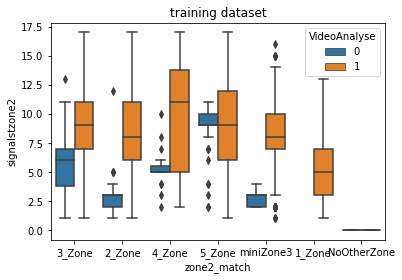

In [21]:
sns.boxplot(x='zone2_match', y='signalstzone2', hue='VideoAnalyse', data=df_cl4stat)
plt.title('training dataset')
plt.savefig(os.path.join(path_extracted_data_cleaning,'videoanalysis_training_zone2_match.png'), bbox_inches='tight')
plt.show();

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


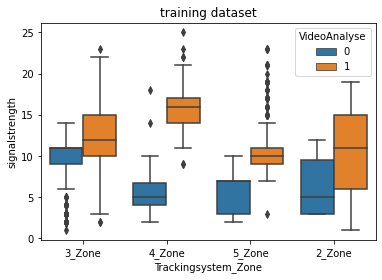

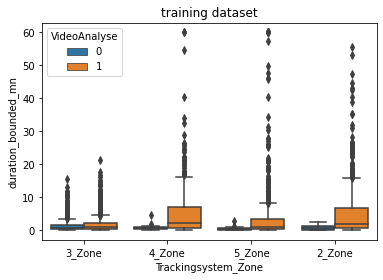

In [19]:
for t in ['signalstrength','duration_bounded_mn']:
    #sns.violinplot(x='Trackingsystem_Zone', y=t, hue='VideoAnalyse', data=df_cl4stat)
    sns.boxplot(x='Trackingsystem_Zone', y=t, hue='VideoAnalyse', data=df_cl4stat)
    plt.title('training dataset')
    plt.savefig(os.path.join(path_extracted_data_cleaning,'videoanalysis_training_'+t+'.png'), bbox_inches='tight')
    plt.show();

In [12]:
#FR/CR percentage
df_cl4stat.groupby(['VideoAnalyse'])['Timestamp'].agg(lambda x: len(list(x))).reset_index() #536/4274=12,5%, 3738/4274=87,45%

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,VideoAnalyse,Timestamp
0,0,536
1,1,3738


In [8]:
df_tt = df_cl4stat.groupby(['TagID'])['Timestamp'].agg(lambda x: len(list(x))).reset_index()
df_tt.sort_values(['Timestamp'], inplace=True, ascending=False)
df_tt['order'] = list(range(0,df_tt.shape[0]))
df_tt
#--> a total of 46 tags involved, with 17 tags involved with more than 100 observations and 35 tags involved in more than 40 observations.

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TagID,Timestamp,order
31,tag_59,352,0
4,tag_125,249,1
30,tag_49,243,2
43,tag_92,188,3
19,tag_2,184,4
41,tag_90,174,5
29,tag_48,169,6
22,tag_3,168,7
42,tag_91,151,8
33,tag_62,135,9


In [9]:
df_tt = df_cl4stat.groupby(['system'])['Timestamp'].agg(lambda x: len(list(x))).reset_index()
df_tt.sort_values(['Timestamp'], inplace=True, ascending=False)
df_tt

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system,Timestamp
1,3 - 5,1740
0,10 - 12,1407
2,8 - 9,1127


In [10]:
df_tt = df_cl4stat.groupby(['Trackingsystem_Zone'])['Timestamp'].agg(lambda x: len(list(x))).reset_index()
df_tt.sort_values(['Timestamp'], inplace=True, ascending=False)
df_tt

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trackingsystem_Zone,Timestamp
1,3_Zone,2393
0,2_Zone,916
3,5_Zone,561
2,4_Zone,404


# Compare models with different random seeds

In [7]:
#compare models using different radom seeds with the selected hyper paramters, by training them on training dataset and 
#comparing them on testing dataset
li_dico = [] #to save accuracies results
li_dico_test = [] #to save McNemar results
for rs in tqdm.tqdm(random.sample(range(0,100000),100)):
    
    ###############################################################################################################################
    ############################################## preprocessing (val. and training) ##############################################
    ###############################################################################################################################

    df_cleaning = df[df['algo_type']=='cleaning'].copy()
    #remove WG from testing (this will only be used for the method comparison)
    df_testing = df[(df['algo_type']=='verification')&(df['Trackingsystem_Zone']!='1_Zone')].copy()
    
    ####### train,test & DUMMIES : RF & GB #######
    #transform categorical data into dumies
    df_cl_d = pd.get_dummies(df_cleaning.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
    df_te_d = pd.get_dummies(df_testing.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
    if len(df_te_d.columns)!=len(df_cl_d.columns):
        print('the test set does not have the same amount of features than the cleaning set, certainly due to low amount of data,\
        Please remove some variables that has missing values in the testing set')
        sys.exit()
    #split into train, test and put into good format
    X_train = df_cl_d.values
    y_train = df_cleaning[['VideoAnalyse']].values
    y_train = np.ravel(y_train)
    X_test = df_te_d.values
    y_test = df_testing[['VideoAnalyse']].values
    y_test = np.ravel(y_test) #from (x,1) to (x,)
    #small control: show rows with at least one nan
    if df_cl_d[df_cl_d.isna().any(axis=1)].shape[0]!=0:
        print('ERROR: you have nan in your cleaning set')
        sys.exit()
    if df_te_d[df_te_d.isna().any(axis=1)].shape[0]!=0:
        print('ERROR: you have nan in your testing set')
        sys.exit()

    ####### train, VAL, test (NO DUMMIES): CB #######
    #we need to keep into dataframe format in order to have the columns names to specify in the hyperparamters the names of the
    #categorical variables
    #split into train, test and validation
    #for algo from sklearn, we should add val+train together, while for the Catboost we will not add them up 
    df_X_train_cb_init = df_cleaning.filter(li_cont_select+li_cat_select, axis=1)
    df_y_train_cb_init = df_cleaning[['VideoAnalyse']]
    df_X_test_cb = df_testing.filter(li_cont_select+li_cat_select, axis=1)
    df_y_test_cb = df_testing[['VideoAnalyse']]

    
    ###############################################################################################################################
    ########################################### model training with different random seed #########################################
    ###############################################################################################################################
    #note that we add the model testing and training accuracy just for verifiation
    dico_name_dico = {}
    ################# Randomforest
    #download the mdoel for the parameters and add the random_state parameter
    model_RF = joblib.load(os.path.join(path_extracted_data_cleaning_model, 'selected_randomforest.pkl')) #need t add "rs"
    dico_p = model_RF.get_params()
    dico_p['random_state'] = rs
    model_RF = RandomForestClassifier(**dico_p)
    model_RF.fit(X_train, y_train)
    dico_RF = {'algo':'RandomForest', 'model':model_RF, 'model_param_used':model_RF.get_params(), 'random_seed':rs,
                'accuracy_training':round(model_RF.score(X_train, y_train),3),
                'accuracy_testing':round(model_RF.score(X_test, y_test),3)}
    dico_name_dico['RandomForest'] = dico_RF

    ################# GradientBoostingClassifier   
    model_GBC = joblib.load(os.path.join(path_extracted_data_cleaning_model, 'selected_GBC.pkl'))
    dico_p = model_GBC.get_params()
    dico_p['random_state'] = rs ; dico_p['tol'] = 0.001
    model_GBC = GradientBoostingClassifier(**dico_p)                                
    model_GBC.fit(X_train, y_train)
    dico_GBC = {'algo':'GradientBoostingClassifier','model':model_GBC,'model_param_used':model_GBC.get_params(),'random_seed':rs,
                'accuracy_training':round(model_GBC.score(X_train, y_train),3),
                'accuracy_testing':round(model_GBC.score(X_test, y_test),3)}
    dico_name_dico['gradientboosintclassifier'] = dico_GBC

    ################# Catboost
    model_CB = CatBoostClassifier() #its needed
    model_CB.load_model(os.path.join(path_extracted_data_cleaning_model,'selected_Catboost'));
    dico_ = model_CB.get_params()
    dico_['random_state'] = rs ; dico_['cat_features'] = np.array(li_cat_select)
    dico_['use_best_model'] = False
    model_CB = CatBoostClassifier(**dico_)
    #model_CB.fit(df_X_train_cb, df_y_train_cb, eval_set=(df_X_val_cb,df_y_val_cb) , verbose=False)
    model_CB.fit(df_X_train_cb_init, df_y_train_cb_init, verbose=False)
    dico_CB = {'algo':'CatBoost', 'model':model_CB, 'model_param_used':model_CB.get_all_params(), 'random_seed':rs,
                'accuracy_training':round(model_CB.score(df_X_train_cb_init, df_y_train_cb_init),3),
                'accuracy_testing':round(model_CB.score(df_X_test_cb, df_y_test_cb),3)}
    dico_name_dico['CatBoost'] = dico_CB

    
    ##########################################################################################################
    ############################### model comparison with performance measures ###############################
    ##########################################################################################################
    for name, dico_model in dico_name_dico.items():
        model = dico_model['model']
        if name=='CatBoost':
            predictions = model.predict(df_X_test_cb)
            prediction_proba = model.predict_proba(df_X_test_cb)
        else:
            predictions = model.predict(X_test)
            prediction_proba = model.predict_proba(X_test)
        df_testing['model_prediction_'+name] = predictions
        df_testing['model_prediction_proba0_'+name] = [round(x[0],2) for x in prediction_proba]
        df_testing['model_prediction_proba1_'+name] = [round(x[1],2) for x in prediction_proba]
        #was the model prediction correct?
        df_testing['model_IsCorrect'+name] = df_testing.apply(lambda x: x['model_prediction_'+name]==x['VideoAnalyse'], axis=1)
        
        #model evaluation
        res = classification_report(df_testing['VideoAnalyse'].astype(int).tolist(), 
                                    df_testing['model_prediction_'+name].astype(int).tolist(), 
                                    output_dict=True, zero_division=0)
        dico_ = res_intodico(res)
        #join the two sets of information together
        dico_model = {**dico_,**dico_model}
        #save info
        li_dico.append(dico_model)
    #df_testing.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'_ModelSelection.csv'), index=False, sep=';')
    #display(df_testing[['TagID','Timestamp','PenID','Zone']+[x for x in df_testing.columns if x.startswith('model_IsCorrect')]].head(5))
    
    
    ##########################################################################################################
    #################################### model comparison with Mcnemar #######################################
    ##########################################################################################################
    ################# Mcnemar RF & GB
    #tranform into a contingency table
    M = [[df_testing[(df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0]],
        [df_testing[(df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0]]]
    #print(M)
    result = mcnemar(M, exact=True) #exact=True: as not all used cells are >25
    #if result.pvalue > alpha:  print('Same proportions of errors (fail to reject H0)')
    li_dico_test.append({'type':'RF - GBC','stat':result.statistic,'pval':result.pvalue})

    ################# Mcnemar RF & CB
    #tranform into a contingency table
    M = [[df_testing[(df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectCatBoost'])].shape[0]],
        [df_testing[(df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0]]]
    result = mcnemar(M, exact=True)
    li_dico_test.append({'type':'RF - CB','stat':result.statistic,'pval':result.pvalue})

    ################# Mcnemar GB & CB
    #tranform into a contingency table
    M = [[df_testing[(df_testing['model_IsCorrectgradientboosintclassifier'])&(df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectgradientboosintclassifier'])&(df_testing['model_IsCorrectCatBoost'])].shape[0]],
        [df_testing[(df_testing['model_IsCorrectgradientboosintclassifier'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectgradientboosintclassifier'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0]]]
    result = mcnemar(M, exact=True)
    li_dico_test.append({'type':'GBC - CB','stat':result.statistic,'pval':result.pvalue})
    
df_results = pd.DataFrame(li_dico) 
#df_results[['accuracy_testing','accuracy']] correct
display(df_results.head(3))

df_test = pd.DataFrame(li_dico_test)    
display(df_test.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:53<00:00,  9.54s/it]


,accuracy,support,macroavg_precision,macroavg_recall,macroavg_f1,weightedavg_precision,weightedavg_recall,weightedavg_f1,0_precision,0_recall,...,1_precision,1_recall,1_f1-score,1_support,algo,model,model_param_used,random_seed,accuracy_training,accuracy_testing
0,0.991647,838,0.959035,0.948120,0.953505,0.959035,0.948120,0.953505,0.923077,0.900,...,0.994994,0.996241,0.995617,798,RandomForest,"(DecisionTreeClassifier(criterion='entropy', m...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",45063,0.993,0.992
1,0.989260,838,0.945589,0.934994,0.940220,0.945589,0.934994,0.940220,0.897436,0.875,...,0.993742,0.994987,0.994364,798,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",45063,0.998,0.989
2,0.988067,838,0.918565,0.958114,0.937335,0.918565,0.958114,0.937335,0.840909,0.925,...,0.996222,0.991228,0.993719,798,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,"{'nan_mode': 'Min', 'eval_metric': 'Logloss', ...",45063,0.998,0.988


,type,stat,pval
0,RF - GBC,0.0,0.500
1,RF - CB,1.0,0.375
2,GBC - CB,3.0,1.000


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


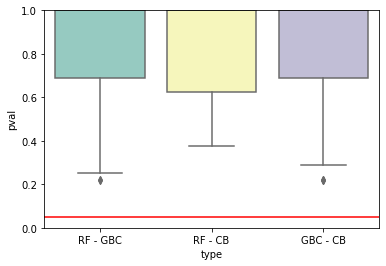

In [8]:
#Mc nemar test 
ax = sns.boxplot(x="type", y="pval", data=df_test, palette="Set3")
ax.set_ylim(0, 1)
ax.axhline(y=.05, color = 'red')
plt.savefig(os.path.join(path_extracted_data_cleaning,'ModelComparison_McNemarTest.png'), bbox_inches='tight')
#we used exact=True, as some cells was<25 obs: https://machinelearningmastery.com/mcnemars-test-for-machine-learning/
#p > alpha: fail to reject H0, similar proportion of errors on the test 
#p <= alpha: reject H0, different proportion of errors

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,algo,accuracy,value
899,CatBoost,1_precision,0.994969
881,CatBoost,1_precision,0.996222
884,CatBoost,1_precision,0.996222


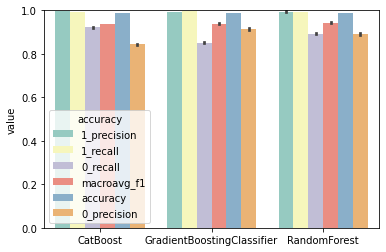

In [9]:
#performance measures
li_perfo = ['0_precision','0_recall','1_precision','1_recall','accuracy','macroavg_f1']
#macro average: averaging the unweighted mean per label
df_plt = pd.melt(df_results, id_vars=['algo'], value_vars=li_perfo)
df_plt.sort_values(['algo'], inplace=True)
df_plt.rename(columns={'variable':'accuracy'}, inplace=True)
display(df_plt.head(3))
ax = sns.barplot(x="algo", y="value", hue="accuracy", data=df_plt, palette="Set3", ci=95)
plt.xlabel('')
plt.ylim(0,1);
plt.savefig(os.path.join(path_extracted_data_cleaning,'ModelSelection_accuracy.png'), bbox_inches='tight')

# Save Selected model with fixed random seed & training on training dataset & testing on testing dataset

In [10]:
df_cleaning = df[df['algo_type']=='cleaning'].copy()
#remove WG from testing (this will only be used for the method comparison)
df_testing = df[(df['algo_type']=='verification')&(df['Trackingsystem_Zone']!='1_Zone')].copy()
df_X_train_cb_init = df_cleaning.filter(li_cont_select+li_cat_select, axis=1)
df_y_train_cb_init = df_cleaning[['VideoAnalyse']]
df_X_test_cb = df_testing.filter(li_cont_select+li_cat_select, axis=1)
df_y_test_cb = df_testing[['VideoAnalyse']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
li_dico = []
#load model in order to use the selected parameterd
model_CB = CatBoostClassifier() #its needed
model_CB.load_model(os.path.join(path_extracted_data_cleaning_model,'selected_Catboost'));
dico_ = model_CB.get_params()
dico_['random_state'] = 0 ; dico_['cat_features'] = np.array(li_cat_select)
dico_['use_best_model'] = False
#initialise a catboost with the chosen parameters and fit to training dataset
model_final = CatBoostClassifier(**dico_)
model_final.fit(df_X_train_cb_init, df_y_train_cb_init, verbose=False)
name_ = 'FINAL_Catboost'
li_dico.append({'algo':name_, 'model_param_used':model_final.get_all_params(), 
                'accuracy_training':round(model_final.score(df_X_train_cb_init, df_y_train_cb_init),3),
                'accuracy_testing':round(model_final.score(df_X_test_cb, df_y_test_cb),3)})
#save
model_final.save_model(os.path.join(path_extracted_data_cleaning_model,name_),format="cbm")
pd.DataFrame(li_dico)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,algo,model_param_used,accuracy_training,accuracy_testing
0,FINAL_Catboost,"{'nan_mode': 'Min', 'eval_metric': 'Logloss', ...",0.998,0.988


In [12]:
model_final.get_params()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'iterations': 500,
 'depth': 6,
 'l2_leaf_reg': 2,
 'loss_function': 'Logloss',
 'od_pval': 1e-06,
 'od_wait': 10,
 'use_best_model': False,
 'verbose': 0,
 'class_weights': [6.973880597, 1],
 'class_names': [0, 1],
 'task_type': 'CPU',
 'random_state': 0,
 'cat_features': array(['Trackingsystem_Zone', 'zone2_match', 'previous1_zone',
        'next1_zone', 'system'], dtype='<U19'),
 'min_data_in_leaf': 1}

### performance on testing dataset

In [13]:
predictions = model_final.predict(df_X_test_cb)
classification_report(df_y_test_cb, predictions, output_dict=True, zero_division=0)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'0': {'precision': 0.8409090909090909,
  'recall': 0.925,
  'f1-score': 0.8809523809523809,
  'support': 40},
 '1': {'precision': 0.9962216624685138,
  'recall': 0.9912280701754386,
  'f1-score': 0.9937185929648241,
  'support': 798},
 'accuracy': 0.9880668257756563,
 'macro avg': {'precision': 0.9185653766888024,
  'recall': 0.9581140350877193,
  'f1-score': 0.9373354869586026,
  'support': 838},
 'weighted avg': {'precision': 0.9888081745659161,
  'recall': 0.9880668257756563,
  'f1-score': 0.988335957546569,
  'support': 838}}

### features importance

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


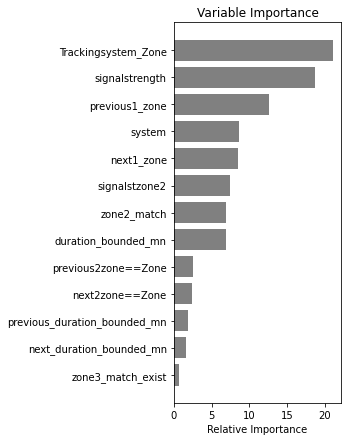

In [14]:
df_fi = model_final.get_feature_importance(prettified=True, type='FeatureImportance').sort_values(['Importances'],ascending=True)
plt.figure(figsize=(3, 7))
pos = [i+0.5 for i in range(0,df_fi.shape[0])]
plt.barh(pos, df_fi['Importances'].tolist(), align='center', color='grey')
plt.yticks(pos, df_fi['Feature Id'].tolist())
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig(os.path.join(path_extracted_data_cleaning,'FeaturesImportance_Catboost.png'), bbox_inches='tight')
plt.show()

In [15]:
df_fi

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Feature Id,Importances
12,zone3_match_exist,0.675664
11,next_duration_bounded_mn,1.550268
10,previous_duration_bounded_mn,1.920712
9,next2zone==Zone,2.448864
8,previous2zone==Zone,2.496575
7,duration_bounded_mn,6.893011
6,zone2_match,6.963439
5,signalstzone2,7.404498
4,next1_zone,8.553789
3,system,8.618204
